In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from methods import CATEGORICAL_COLS, propensity, plot_propensity_hist, ipw, s_learner, t_learner, matching_1NN, \
        matching_general
import pandas as pd
import pickle
from tqdm import tqdm
import numpy as np

Read data

In [3]:
with open('data/consecutive_games_df.pkl', 'rb') as handle:
    full_df = pickle.load(handle)

In [4]:
full_df = full_df[(full_df['prev_goal_diff'] == 1) | (full_df['prev_goal_diff'] == -1)]

In [5]:
full_df['time_between_games'] = (full_df['next_date'] - full_df['prev_date']).apply(lambda x: x.days)

In [6]:
full_df['lost_prev_game'] = full_df['prev_goal_diff'] < 0

In [7]:
def bootstrap(df, method, N, **args):
    np.random.seed(42)
    values = []
    for _ in tqdm(range(N)):
        sample_df = df.sample(len(df), replace=True)
        values.append(method(sample_df, **args))
    return values

In [8]:
def create_estimation_series_from_bootstrap(bootstrap_vec, name):
    index = ['ATE Estimation', 'ATE Condifence_Interval']
    estimation = round(np.mean(bootstrap_vec), 3)
    confidence_interval = (round(np.quantile(bootstrap_vec, 0.025), 3), round(np.quantile(bootstrap_vec, 0.975), 3))
    return pd.Series([estimation, confidence_interval], index=index, name=name)

# Question 1
<b>How does the outcome of a match affect the team’s outcome in their following match?

In [9]:
drop_cols = ['row_team', 'league_id', 'prev_match_api_id', 'prev_date', 'prev_rival_team_api_id', 'next_match_api_id', 
             'next_date', 'next_rival_team_api_id', 'next_rival_team_goal', 'prev_goal_diff',
             'next_row_team_goal', 'prev_row_team_goal', 'prev_rival_team_goal']

bet_cols = [col for col in full_df.columns if '_bet_' in col]
T = 'lost_prev_game'
Y = 'next_goal_diff'
X_COLS = [col for col in full_df.columns if col not in drop_cols + bet_cols + [Y, T] + CATEGORICAL_COLS]

In [10]:
df = full_df.drop(columns=drop_cols)

# Propensity and IPW
We'll use Logistic Regression

### Propensity

In [11]:
prop = propensity(df, X_COLS, T)
print(f'Data Propensity: \n{prop}')

Data Propensity: 
[0.60970903 0.39783524 0.76448259 ... 0.71669506 0.28736252 0.74828526]


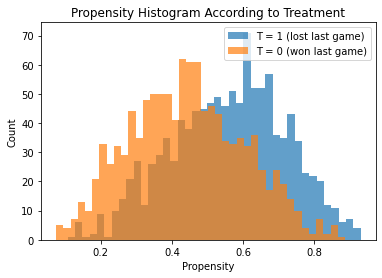

In [12]:
t = df[T].to_numpy()
plot_propensity_hist(t, prop)


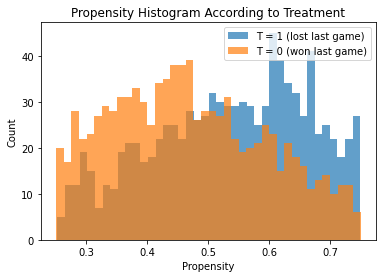

In [13]:
df['prop'] = prop
df = df[(df['prop'] > 0.25) & (df['prop'] < 0.75)]
t = df[T].to_numpy()
prop = df['prop'].to_numpy()
plot_propensity_hist(t, prop)

### IPW

In [25]:
ipw_bootstrap = bootstrap(df, ipw, N=1000, x_cols=X_COLS, T=T, Y=Y)

 38%|██████████████████████████████▎                                                | 384/1000 [00:31<00:41, 14.68it/s]C:\Users\EB\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 40%|███████████████████████████████▍                                               | 398/1000 [00:32<00:39, 15.33it/s]C:\Users\EB\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as sho

In [26]:
ipw_series = create_estimation_series_from_bootstrap(ipw_bootstrap, 'IPW')
ipw_series

ATE Estimation                       0.134
ATE Condifence_Interval    (-0.011, 0.279)
Name: IPW, dtype: object

# S-Learner

### No interactions:

In [16]:
s_bootstrap = bootstrap(df, s_learner, N=1000, T=T, Y=Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 15.08it/s]


In [17]:
s_learner_series = create_estimation_series_from_bootstrap(s_bootstrap, 'S-Learner')
s_learner_series

ATE Estimation                      0.083
ATE Condifence_Interval    (0.011, 0.155)
Name: S-Learner, dtype: object

### With interactions:

In [18]:
s_bootstrap_interactions = bootstrap(df, s_learner, N=1000, T=T, Y=Y, use_interactions=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:34<00:00,  2.99it/s]


In [19]:
s_learner_interactions_series = create_estimation_series_from_bootstrap(s_bootstrap_interactions, 'S-Learner Interactions')
s_learner_interactions_series

ATE Estimation                      0.115
ATE Condifence_Interval    (0.017, 0.219)
Name: S-Learner Interactions, dtype: object

# T-Learner

In [20]:
t_bootstrap = bootstrap(df, t_learner, N=1000, T=T, Y=Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:41<00:00,  9.82it/s]


In [21]:
t_learner_series = create_estimation_series_from_bootstrap(t_bootstrap, 'T-Learner')
t_learner_series

ATE Estimation                      0.167
ATE Condifence_Interval    (0.025, 0.308)
Name: T-Learner, dtype: object

# Matching

### 1NN

In [22]:
matching_1nn_bootstrap = bootstrap(df, matching_1NN, N=1000, T=T, Y=Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.54it/s]


In [23]:
matching_1nn_series = create_estimation_series_from_bootstrap(matching_1nn_bootstrap, '1NN Matching')
matching_1nn_series

ATE Estimation                      0.243
ATE Condifence_Interval    (0.048, 0.429)
Name: 1NN Matching, dtype: object

### 10NN

In [27]:
matching_10nn_bootstrap = bootstrap(df, matching_general, N=1000, T=T, Y=Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:47<00:00,  4.39it/s]


In [28]:
matching_10nn_series = create_estimation_series_from_bootstrap(matching_10nn_bootstrap, '10NN Matching')
matching_10nn_series

ATE Estimation                      0.226
ATE Condifence_Interval    (0.054, 0.402)
Name: 10NN Matching, dtype: object

In [29]:
results_df = pd.concat([ipw_series, s_learner_series, s_learner_interactions_series, t_learner_series, matching_1nn_series, 
           matching_10nn_series], axis=1).T
print("The mean ATE Estimation is: ", round(results_df['ATE Estimation'].mean(), 3))
results_df

The mean ATE Estimation is:  0.161


,ATE Estimation,ATE Condifence_Interval
IPW,0.134,"(-0.011, 0.279)"
S-Learner,0.083,"(0.011, 0.155)"
S-Learner Interactions,0.115,"(0.017, 0.219)"
T-Learner,0.167,"(0.025, 0.308)"
1NN Matching,0.243,"(0.048, 0.429)"
10NN Matching,0.226,"(0.054, 0.402)"


# Question 2
<b>How does the outcome of a match affect the betting odds in the team’s following match?

In [30]:
drop_cols = ['row_team', 'league_id', 'prev_match_api_id', 'prev_date', 'prev_rival_team_api_id', 'next_match_api_id', 
             'next_date', 'next_rival_team_api_id', 'next_rival_team_goal', 'prev_goal_diff',
             'next_row_team_goal', 'prev_row_team_goal', 'prev_rival_team_goal']
bet_cols = [col for col in full_df.columns if '_bet_' in col]
T = 'lost_prev_game'
Y = 'next_mean_bet_row_team'
X_COLS = [col for col in full_df.columns if col not in drop_cols + bet_cols + [Y, T] + CATEGORICAL_COLS]

In [31]:
df = full_df.drop(columns=drop_cols)

# Propensity and IPW
We'll use Logistic Regression

### Propensity

In [32]:
prop = propensity(df, X_COLS, T)
print(f'Data Propensity: \n{prop}')

Data Propensity: 
[0.61249837 0.36399415 0.75605802 ... 0.74039119 0.26900683 0.76287767]


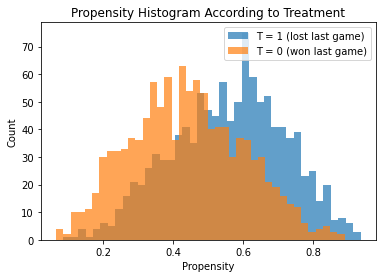

In [33]:
t = df[T].to_numpy()
plot_propensity_hist(t, prop)


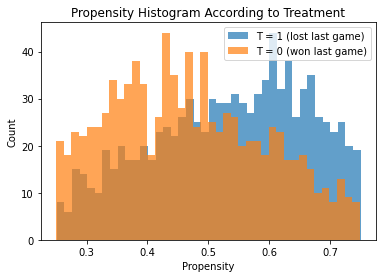

In [34]:
df['prop'] = prop
df = df[(df['prop'] > 0.25) & (df['prop'] < 0.75)]
t = df[T].to_numpy()
prop = df['prop'].to_numpy()
plot_propensity_hist(t, prop)

### IPW

In [35]:
ipw_bootstrap2 = bootstrap(df, ipw, N=1000, x_cols=X_COLS, T=T, Y=Y)

 50%|███████████████████████████████████████▊                                       | 504/1000 [00:32<00:31, 15.54it/s]C:\Users\EB\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 63%|█████████████████████████████████████████████████▌                             | 628/1000 [00:40<00:23, 15.64it/s]C:\Users\EB\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as sho

In [36]:
ipw_series2 = create_estimation_series_from_bootstrap(ipw_bootstrap2, 'IPW')
ipw_series2

ATE Estimation                      0.171
ATE Condifence_Interval    (0.017, 0.328)
Name: IPW, dtype: object

# S-Learner

### No interactions:

In [37]:
s_bootstrap2 = bootstrap(df, s_learner, N=1000, T=T, Y=Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 15.92it/s]


In [38]:
s_learner_series2 = create_estimation_series_from_bootstrap(s_bootstrap2, 'S-Learner')
s_learner_series2

ATE Estimation                       0.004
ATE Condifence_Interval    (-0.019, 0.027)
Name: S-Learner, dtype: object

### With interactions:

In [39]:
s_bootstrap_interactions2 = bootstrap(df, s_learner, N=1000, T=T, Y=Y, use_interactions=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:09<00:00,  3.23it/s]


In [40]:
s_learner_interactions_series2 = create_estimation_series_from_bootstrap(s_bootstrap_interactions2, 'S-Learner Interactions')
s_learner_interactions_series2

ATE Estimation                      -0.001
ATE Condifence_Interval    (-0.023, 0.022)
Name: S-Learner Interactions, dtype: object

# T-Learner

In [41]:
t_bootstrap2 = bootstrap(df, t_learner, N=1000, T=T, Y=Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:19<00:00, 12.54it/s]


In [42]:
t_learner_series2 = create_estimation_series_from_bootstrap(t_bootstrap2, 'T-Learner')
t_learner_series2

ATE Estimation                      0.005
ATE Condifence_Interval    (-0.04, 0.051)
Name: T-Learner, dtype: object

# Matching

### 1NN

In [43]:
matching_1nn_bootstrap2 = bootstrap(df, matching_1NN, N=1000, T=T, Y=Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.81it/s]


In [44]:
matching_1nn_series2 = create_estimation_series_from_bootstrap(matching_1nn_bootstrap2, '1NN Matching')
matching_1nn_series2

ATE Estimation                       0.034
ATE Condifence_Interval    (-0.186, 0.239)
Name: 1NN Matching, dtype: object

### 10NN

In [45]:
matching_10nn_bootstrap2 = bootstrap(df, matching_general, N=1000, T=T, Y=Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:41<00:00,  4.52it/s]


In [46]:
matching_10nn_series2 = create_estimation_series_from_bootstrap(matching_10nn_bootstrap2, '10NN Matching')
matching_10nn_series2

ATE Estimation                       0.035
ATE Condifence_Interval    (-0.162, 0.222)
Name: 10NN Matching, dtype: object

In [47]:
results_df2 = pd.concat([ipw_series2, s_learner_series2, s_learner_interactions_series2, t_learner_series2, matching_1nn_series2, 
           matching_10nn_series2], axis=1).T
print("The mean ATE Estimation is: ", round(results_df2['ATE Estimation'].mean(), 3))
results_df2

The mean ATE Estimation is:  0.041


,ATE Estimation,ATE Condifence_Interval
IPW,0.171,"(0.017, 0.328)"
S-Learner,0.004,"(-0.019, 0.027)"
S-Learner Interactions,-0.001,"(-0.023, 0.022)"
T-Learner,0.005,"(-0.04, 0.051)"
1NN Matching,0.034,"(-0.186, 0.239)"
10NN Matching,0.035,"(-0.162, 0.222)"


# Question 1 - no season info
<b>How does the outcome of a match affect the team’s outcome in their following match?

In [48]:
drop_cols = ['row_team', 'league_id', 'prev_match_api_id', 'prev_date', 'prev_rival_team_api_id', 'next_match_api_id', 
             'next_date', 'next_rival_team_api_id', 'next_rival_team_goal', 'prev_goal_diff',
             'next_row_team_goal', 'prev_row_team_goal', 'prev_rival_team_goal']

bet_cols = [col for col in full_df.columns if '_bet_' in col]
T = 'lost_prev_game'
Y = 'next_goal_diff'
X_COLS = [col for col in full_df.columns if col not in drop_cols + bet_cols + [Y, T] + CATEGORICAL_COLS]

In [49]:
next_season_cols = ['row_team_wins', 'row_team_draws', 'row_team_league_points', 'row_team_season_goals','prev_rival_wins',
                     'prev_rival_draws', 'prev_rival_league_points', 'prev_rival_season_goals', 'next_rival_wins', 
                    'next_rival_draws', 'next_rival_league_points', 'next_rival_season_goals',]
X_COLS = [col for col in X_COLS if col not in next_season_cols]

In [50]:
df = full_df.drop(columns=drop_cols)

# Propensity and IPW
We'll use Logistic Regression

### Propensity

In [51]:
prop = propensity(df, X_COLS, T)
print(f'Data Propensity: \n{prop}')

Data Propensity: 
[0.62930478 0.36597891 0.66599518 ... 0.63516577 0.50496879 0.55741501]


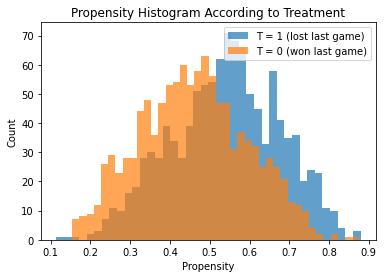

In [52]:
t = df[T].to_numpy()
plot_propensity_hist(t, prop)


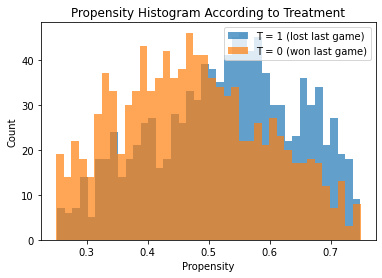

In [53]:
df['prop'] = prop
df = df[(df['prop'] > 0.25) & (df['prop'] < 0.75)]
t = df[T].to_numpy()
prop = df['prop'].to_numpy()
plot_propensity_hist(t, prop)

### IPW

In [54]:
ipw_bootstrap = bootstrap(df, ipw, N=1000, x_cols=X_COLS, T=T, Y=Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.23it/s]


In [55]:
ipw_series = create_estimation_series_from_bootstrap(ipw_bootstrap, 'IPW')
ipw_series

ATE Estimation                       0.092
ATE Condifence_Interval    (-0.045, 0.234)
Name: IPW, dtype: object

# S-Learner

### No interactions:

In [56]:
s_bootstrap = bootstrap(df, s_learner, N=1000, T=T, Y=Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:22<00:00, 12.17it/s]


In [57]:
s_learner_series = create_estimation_series_from_bootstrap(s_bootstrap, 'S-Learner')
s_learner_series

ATE Estimation                     0.096
ATE Condifence_Interval    (0.031, 0.16)
Name: S-Learner, dtype: object

### With interactions:

In [58]:
s_bootstrap_interactions = bootstrap(df, s_learner, N=1000, T=T, Y=Y, use_interactions=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:39<00:00,  2.94it/s]


In [59]:
s_learner_interactions_series = create_estimation_series_from_bootstrap(s_bootstrap_interactions, 'S-Learner Interactions')
s_learner_interactions_series

ATE Estimation                     0.114
ATE Condifence_Interval    (0.02, 0.212)
Name: S-Learner Interactions, dtype: object

# T-Learner

In [60]:
t_bootstrap = bootstrap(df, t_learner, N=1000, T=T, Y=Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:22<00:00, 12.05it/s]


In [61]:
t_learner_series = create_estimation_series_from_bootstrap(t_bootstrap, 'T-Learner')
t_learner_series

ATE Estimation                      0.198
ATE Condifence_Interval    (0.069, 0.331)
Name: T-Learner, dtype: object

# Matching

### 1NN

In [62]:
matching_1nn_bootstrap = bootstrap(df, matching_1NN, N=1000, T=T, Y=Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.98it/s]


In [63]:
matching_1nn_series = create_estimation_series_from_bootstrap(matching_1nn_bootstrap, '1NN Matching')
matching_1nn_series

ATE Estimation                      0.235
ATE Condifence_Interval    (0.056, 0.417)
Name: 1NN Matching, dtype: object

### 10NN

In [64]:
matching_10nn_bootstrap = bootstrap(df, matching_general, N=1000, T=T, Y=Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:03<00:00,  4.10it/s]


In [65]:
matching_10nn_series = create_estimation_series_from_bootstrap(matching_10nn_bootstrap, '10NN Matching')
matching_10nn_series

ATE Estimation                      0.225
ATE Condifence_Interval    (0.061, 0.385)
Name: 10NN Matching, dtype: object

In [66]:
results_df = pd.concat([ipw_series, s_learner_series, s_learner_interactions_series, t_learner_series, matching_1nn_series, 
           matching_10nn_series], axis=1).T
print("The mean ATE Estimation is: ", round(results_df['ATE Estimation'].mean(), 3))
results_df

The mean ATE Estimation is:  0.16


,ATE Estimation,ATE Condifence_Interval
IPW,0.092,"(-0.045, 0.234)"
S-Learner,0.096,"(0.031, 0.16)"
S-Learner Interactions,0.114,"(0.02, 0.212)"
T-Learner,0.198,"(0.069, 0.331)"
1NN Matching,0.235,"(0.056, 0.417)"
10NN Matching,0.225,"(0.061, 0.385)"
